# Hough Line

Author: YinTaiChen

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

class imageLoader:
    def __init__(self, image):
        %matplotlib inline
        self.img = Image.open(image)
        self.gray = self.img.convert(mode="L")
        self.array_3d = np.array(self.img)
        self.array_1d = np.array(self.gray)
        self.histogram = None
        self.otsu = None
           
    def show(self):
        plt.imshow(self.img)
        
    def grayHist(self):
        height, width = self.array_1d.shape
        grayHist = np.zeros([256], np.uint64)
        
        for i in range(height):
            for j in range(width):
                grayHist[self.array_1d[i][j]] += 1
                
        self.histogram = grayHist
        
    def otsuThres(self):
        input = self.array_1d
        height, width = input.shape
        self.grayHist()
        histogram = self.histogram
        uniformGrayHist = histogram/float(height * width)
        zeroCumuMoment = np.zeros([256], np.float32)
        oneCumuMoment = np.zeros([256], np.float32)
        
        for k in range(256):
            if k == 0:
                zeroCumuMoment[k] = uniformGrayHist[0]
                oneCumuMoment[k] = (k)*uniformGrayHist[0]
            else:
                zeroCumuMoment[k] = zeroCumuMoment[k-1] + uniformGrayHist[k]
                oneCumuMoment[k] = oneCumuMoment[k-1] + k*uniformGrayHist[k]
                
        variance = np.zeros([256], np.float32)
        
        for k in range(255):
            if zeroCumuMoment[k] == 0 or zeroCumuMoment[k] == 1:
                variance[k] = 0
            else:
                variance[k] = math.pow(oneCumuMoment[255]*zeroCumuMoment[k]-oneCumuMoment[k],2)/(zeroCumuMoment[k]*(1.0-zeroCumuMoment[k]))
        
        threshLoc = np.where(variance[0:255] == np.max(variance[0:255]))
        thresh = threshLoc[0][0]
        
        blur = cv2.GaussianBlur(input,(5,5),0)
        
        threshold = blur
        threshold[threshold > thresh] = 255
        threshold[threshold <= thresh] = 0
        
        self.otsu = threshold
        
    def houghLine(self, stepTheta=1, stepRho=1, voteThresh=60):
        self.otsuThres()
        input = self.otsu
        edge = cv2.Canny(input, 50, 200)
        height, width = edge.shape
        L = round(math.sqrt(pow(height-1, 2.0)+pow(width-1, 2.0)))+1
        numtheta = int(180.0/stepTheta)
        numRho = int(2*L/stepRho + 1)
        accumulator = np.zeros((numRho, numtheta), np.int32)
        accuDict = {}
        
        for i in range(numRho):
            for j in range(numtheta):
                accuDict[(i,j)] = []
                
        for h in range(height):
            for w in range(width):
                if(edge[h][w] == 255):
                    for i in range(numtheta):
                        rho = w*math.cos(stepTheta*i/180.0*math.pi) + h*math.sin(stepTheta*i/180.0*math.pi)
                        n = int(round(rho+L)/stepRho)
                        accumulator[n,i] += 1
                        accuDict[(n,i)].append((h,w))
                        
        grayAccu = accumulator/float(np.max(accumulator))
        grayAccu *= 255
        grayAccu = grayAccu.astype(np.uint8)
        
        h_accu, w_accu = accumulator.shape
        
        blank = np.zeros((height, width))
        
        for h in range(h_accu):
            for w in range(w_accu):
                if accumulator[h][w] > voteThresh:
                    points = accuDict[(h,w)]
                    cv2.line(blank, (points[0][1], points[0][0]), (points[len(points)-1][1],points[len(points)-1][0]), (255), 2)
        
        plt.imshow(blank, cmap='gray')

In [2]:
image = imageLoader("Road.jpg")

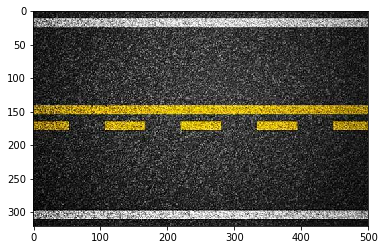

In [3]:
image.show()

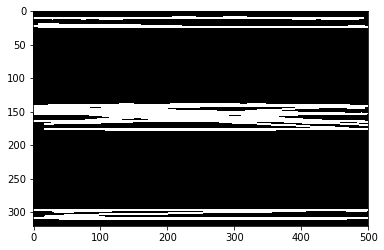

In [4]:
image.houghLine()

In [5]:
image = imageLoader("Lenna.png")

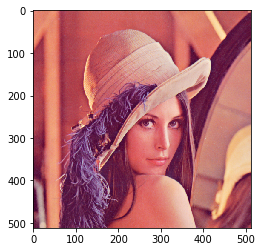

In [6]:
image.show()

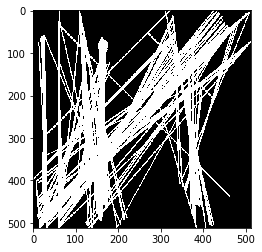

In [7]:
image.houghLine()